<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/verao_covid_casos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import io
import gzip
import pandas as pd
import seaborn as sns; sns.set_theme(style="whitegrid")

In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, parse_dates=["date"], dtype={"city_ibge_code": str})

In [ ]:
cols = "MUNICIPIO","COD_IBGE","CLUSTER","UF","ARRECADACAO","QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL"
cidades_turisticas = pd.read_excel('https://github.com/mirianbatista/covid-fatores/blob/master/RELATORIO_CATEGORIZACAO_2019-Portal.xls?raw=true', usecols=cols, dtype={"COD_IBGE": str})
cidades = cidades_turisticas.MUNICIPIO.to_list()

In [ ]:
cidades_turisticas[cidades_turisticas.isna().any(axis=1)]

,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER


In [ ]:
covid_cidades_turisticas = covid.loc[covid['city'].isin(cidades)]
covid_cidades_turisticas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182025 entries, 0 to 2337326
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype         
---  ------                                         --------------    -----         
 0   city                                           1182025 non-null  object        
 1   city_ibge_code                                 1182025 non-null  object        
 2   date                                           1182025 non-null  datetime64[ns]
 3   epidemiological_week                           1182025 non-null  int64         
 4   estimated_population                           1182025 non-null  float64       
 5   estimated_population_2019                      1182025 non-null  float64       
 6   is_last                                        1182025 non-null  bool          
 7   is_repeated                                    1182025 non-null  bool          
 8   last_available_confirmed        

In [ ]:
covid_cidades_turisticas.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
covid_tur = pd.merge(covid_cidades_turisticas, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left").dropna(subset=['CLUSTER'])
covid_tur = covid_tur[covid_tur.estimated_population >= 20000]

In [ ]:
def aumento_percentual(t0, t1):
  return (t1-t0)/t0 if t0 != 0 else 0

def calcula_aumento_relativo(df, x_col, date_col, from_date, to_date):
    from_x = int(df[df[date_col] == from_date][x_col])
    to_x = int(df[df[date_col] == to_date][x_col])
    abs_dif = to_x - from_x
    relative_dif = aumento_percentual(from_x, to_x)
    return {f'{x_col}_from': from_x, f'{x_col}_to': to_x, 'dif': abs_dif,'relative_dif': relative_dif}

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_confirmed', date_col='date', from_date='2020-12-17', to_date='2021-03-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif
527,3154002,23711.0,212.0,1147.0,935.0,4.410377
1029,4315305,22607.0,96.0,489.0,393.0,4.093750
754,3527405,21886.0,122.0,539.0,417.0,3.418033
462,3121605,47825.0,277.0,1201.0,924.0,3.335740
817,3550100,41123.0,427.0,1851.0,1424.0,3.334895
...,...,...,...,...,...,...
114,2105104,27269.0,214.0,217.0,3.0,0.014019
96,2100907,46771.0,589.0,596.0,7.0,0.011885
109,2103406,49621.0,1580.0,1591.0,11.0,0.006962
77,1508035,31257.0,589.0,593.0,4.0,0.006791


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,6997.0,14166.0,7169.0,1.024582,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,3512.0,8352.0,4840.0,1.378132,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,3513.0,4858.0,1345.0,0.382864,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,1527.0,2705.0,1178.0,0.771447,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,869.0,3279.0,2410.0,2.773303,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,413.0,864.0,451.0,1.092010,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,3992.0,5659.0,1667.0,0.417585,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,1256.0,2424.0,1168.0,0.929936,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,7981.0,9342.0,1361.0,0.170530,GO,Valparaíso de Goiás,5221858,3064,746468,D


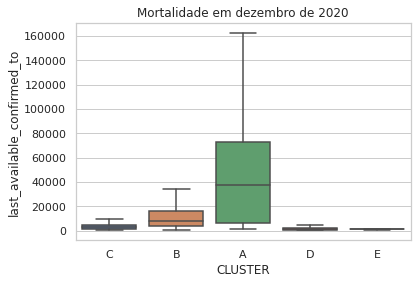

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_confirmed_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em dezembro de 2020")

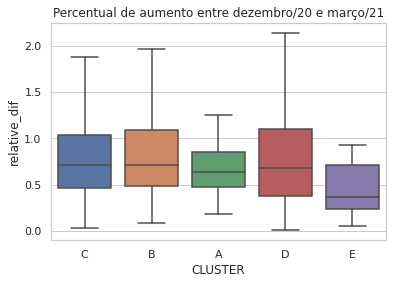

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre dezembro/20 e março/21")

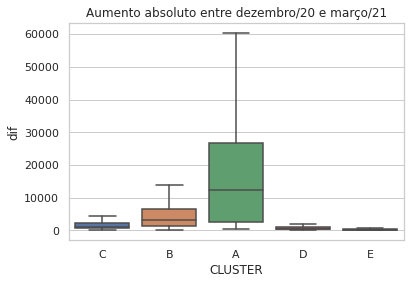

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre dezembro/20 e março/21")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_confirmed_from_mean=('last_available_confirmed_from','mean'),
    last_available_confirmed_from_median=('last_available_confirmed_from','median'),
    last_available_confirmed_to_mean=('last_available_confirmed_to','mean'),
    last_available_confirmed_to_median=('last_available_confirmed_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_confirmed_from_mean,last_available_confirmed_from_median,last_available_confirmed_to_mean,last_available_confirmed_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,37681.423729,26053.0,59503.237288,37875.0,21821.813559,12379.0,0.705813,0.634128,0.599793
1,B,238,183898.054622,123057.0,6416.794118,4224.5,10775.386555,7562.0,4358.592437,3245.5,0.825626,0.708757,0.737972
2,C,397,74728.382872,51338.0,2444.753149,1647.0,4084.395466,2981.0,1639.642317,1168.0,0.833700,0.713062,0.764513
3,D,450,39418.280000,30428.5,1145.031111,836.5,1910.448889,1480.0,765.417778,585.0,0.830198,0.681011,0.765202
4,E,11,39515.181818,24382.0,1061.363636,774.0,1639.272727,1044.0,577.909091,237.0,0.530522,0.361656,0.667365


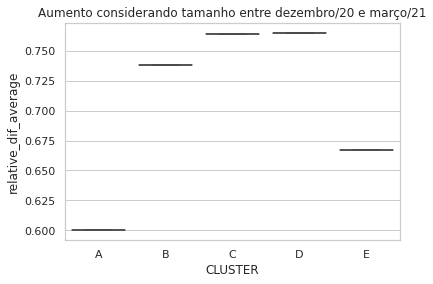

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre dezembro/20 e março/21")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,12379.0
1,B,3245.5
2,C,1168.0
3,D,585.0
4,E,237.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
2,C,0.713062
1,B,0.708757
3,D,0.681011
0,A,0.634128
4,E,0.361656


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
3,D,0.765202
2,C,0.764513
1,B,0.737972
4,E,0.667365
0,A,0.599793


In [ ]:
covid_tur_aumento_categorias.groupby('CLUSTER')['UF'].value_counts().to_frame().unstack()

UF                              ...                                  
UF        AC    AL   AM   AP    BA    CE  ...   RR    RS    SC    SE    SP   TO
CLUSTER                                   ...                                  
A        1.0   2.0  1.0  1.0   4.0   2.0  ...  1.0   2.0   5.0   1.0  11.0  1.0
B        NaN   1.0  NaN  NaN  19.0  12.0  ...  NaN  21.0  15.0   NaN  46.0  2.0
C        2.0   6.0  9.0  2.0  25.0  23.0  ...  NaN  29.0  18.0   6.0  73.0  5.0
D        3.0  16.0  9.0  1.0  30.0  15.0  ...  1.0  41.0  17.0  13.0  67.0  1.0
E        NaN   2.0  NaN  NaN   3.0   1.0  ...  NaN   NaN   1.0   NaN   1.0  NaN

[5 rows x 27 columns]

http://dados.turismo.gov.br/categorizacao


# **Entre 17 de dezembro de 2020 e 16 de janeiro de 2021**

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_confirmed', date_col='date', from_date='2020-12-17', to_date='2021-01-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif
527,3154002,23711.0,212.0,573.0,361.0,1.702830
623,3303856,27858.0,327.0,760.0,433.0,1.324159
817,3550100,41123.0,427.0,954.0,527.0,1.234192
4,1100189,36881.0,869.0,1772.0,903.0,1.039125
1022,4313904,44128.0,989.0,2010.0,1021.0,1.032356
...,...,...,...,...,...,...
110,2103703,32626.0,639.0,639.0,0.0,0.000000
495,3141405,20759.0,306.0,306.0,0.0,0.000000
525,3152204,37864.0,651.0,651.0,0.0,0.000000
107,2103174,21840.0,634.0,634.0,0.0,0.000000


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,6997.0,8937.0,1940.0,0.277262,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,3512.0,5153.0,1641.0,0.467255,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,3513.0,3821.0,308.0,0.087674,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,1527.0,1869.0,342.0,0.223969,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,869.0,1772.0,903.0,1.039125,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,413.0,463.0,50.0,0.121065,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,3992.0,4281.0,289.0,0.072395,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,1256.0,1476.0,220.0,0.175159,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,7981.0,8306.0,325.0,0.040722,GO,Valparaíso de Goiás,5221858,3064,746468,D


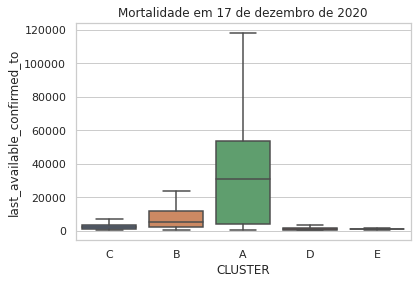

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_confirmed_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em 17 de dezembro de 2020")

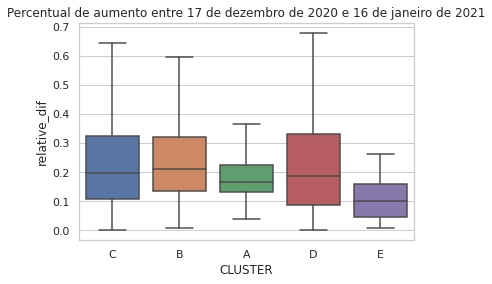

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

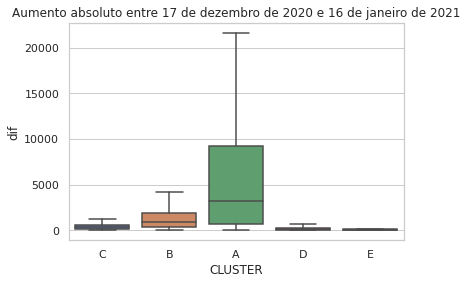

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_confirmeds_from_mean=('last_available_confirmed_from','mean'),
    last_available_confirmed_from_median=('last_available_confirmed_from','median'),
    last_available_confirmed_to_mean=('last_available_confirmed_to','mean'),
    last_available_confirmed_to_median=('last_available_confirmed_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_confirmeds_from_mean,last_available_confirmed_from_median,last_available_confirmed_to_mean,last_available_confirmed_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,37681.423729,26053.0,44001.762712,30897.0,6320.338983,3248.0,0.197560,0.165606,0.172642
1,B,238,183898.054622,123057.0,6416.794118,4224.5,7793.613445,5114.5,1376.819328,891.0,0.247918,0.210345,0.231662
2,C,397,74728.382872,51338.0,2444.753149,1647.0,2926.745592,2040.0,481.992443,335.0,0.247910,0.196170,0.222747
3,D,450,39418.280000,30428.5,1145.031111,836.5,1376.431111,1038.0,231.400000,156.5,0.241997,0.185249,0.226801
4,E,11,39515.181818,24382.0,1061.363636,774.0,1217.090909,852.0,155.727273,76.0,0.124089,0.101813,0.179050


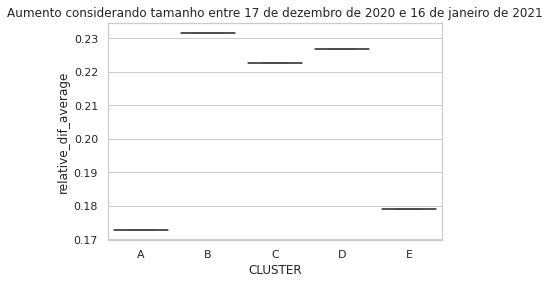

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,3248.0
1,B,891.0
2,C,335.0
3,D,156.5
4,E,76.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.210345
2,C,0.196170
3,D,0.185249
0,A,0.165606
4,E,0.101813


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
1,B,0.231662
3,D,0.226801
2,C,0.222747
4,E,0.179050
0,A,0.172642


# **Entre 17 de janeiro de 2021 e 16 de fevereiro de 2021**

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_confirmed', date_col='date', from_date='2021-01-17', to_date='2021-02-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif
484,3135803,25474.0,240.0,747.0,507.0,2.112500
754,3527405,21886.0,189.0,427.0,238.0,1.259259
495,3141405,20759.0,306.0,595.0,289.0,0.944444
462,3121605,47825.0,488.0,910.0,422.0,0.864754
501,3144102,20545.0,276.0,502.0,226.0,0.818841
...,...,...,...,...,...,...
521,3151404,28215.0,306.0,306.0,0.0,0.000000
1044,4318507,27721.0,491.0,491.0,0.0,0.000000
95,2100204,22112.0,202.0,202.0,0.0,0.000000
96,2100907,46771.0,589.0,589.0,0.0,0.000000


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,9010.0,11186.0,2176.0,0.241509,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,5190.0,7523.0,2333.0,0.449518,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,3822.0,4506.0,684.0,0.178964,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,1897.0,2351.0,454.0,0.239325,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,1772.0,2711.0,939.0,0.529910,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,463.0,607.0,144.0,0.311015,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,4281.0,4903.0,622.0,0.145293,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,1476.0,1721.0,245.0,0.165989,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,8313.0,8779.0,466.0,0.056057,GO,Valparaíso de Goiás,5221858,3064,746468,D


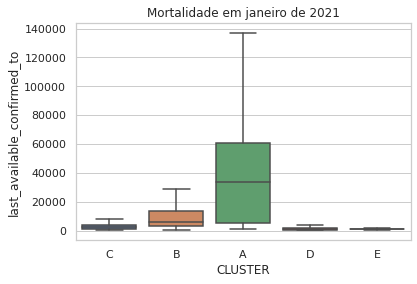

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_confirmed_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em janeiro de 2021")

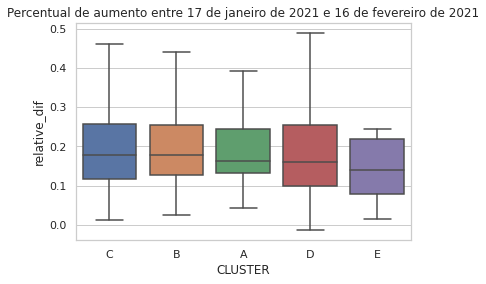

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

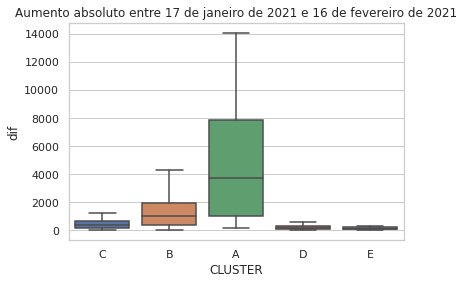

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_confirmed_from_mean=('last_available_confirmed_from','mean'),
    last_available_confirmed_from_median=('last_available_confirmed_from','median'),
    last_available_confirmed_to_mean=('last_available_confirmed_to','mean'),
    last_available_confirmed_to_median=('last_available_confirmed_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_confirmed_from_mean,last_available_confirmed_from_median,last_available_confirmed_to_mean,last_available_confirmed_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,44155.406780,31026.0,51245.525424,33819.0,7090.118644,3762.0,0.202229,0.162640,0.167841
1,B,238,183898.054622,123057.0,7824.084034,5131.5,9233.953782,6230.5,1409.869748,994.0,0.208870,0.178601,0.190637
2,C,397,74728.382872,51338.0,2937.355164,2059.0,3474.335013,2521.0,536.979849,348.0,0.206635,0.178964,0.202071
3,D,450,39418.280000,30428.5,1381.653333,1049.0,1620.808889,1279.0,239.155556,188.0,0.205877,0.160382,0.190751
4,E,11,39515.181818,24382.0,1217.909091,853.0,1432.727273,941.0,214.818182,96.0,0.177464,0.139004,0.204877


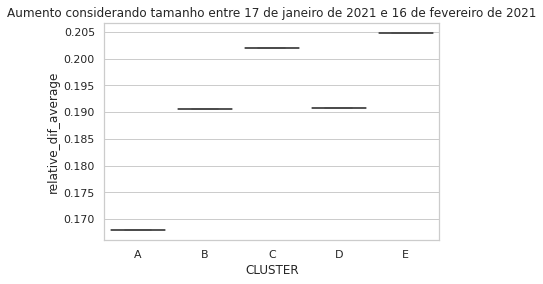

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,3762.0
1,B,994.0
2,C,348.0
3,D,188.0
4,E,96.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
2,C,0.178964
1,B,0.178601
0,A,0.162640
3,D,0.160382
4,E,0.139004


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.204877
2,C,0.202071
3,D,0.190751
1,B,0.190637
0,A,0.167841


# **Entre 17 de fevereiro de 2021 e 16 de março de 2021**

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_confirmed', date_col='date', from_date='2021-02-17', to_date='2021-03-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif
1029,4315305,22607.0,117.0,489.0,372.0,3.179487
449,3114402,21268.0,168.0,441.0,273.0,1.625000
1014,4311007,26500.0,536.0,1106.0,570.0,1.063433
1026,4314605,20704.0,178.0,316.0,138.0,0.775281
1018,4313201,21536.0,1090.0,1900.0,810.0,0.743119
...,...,...,...,...,...,...
102,2101905,21299.0,264.0,265.0,1.0,0.003788
111,2104057,42527.0,3140.0,3150.0,10.0,0.003185
109,2103406,49621.0,1590.0,1591.0,1.0,0.000629
77,1508035,31257.0,593.0,593.0,0.0,0.000000


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_confirmed_from,last_available_confirmed_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,11275.0,14166.0,2891.0,0.256408,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,7557.0,8352.0,795.0,0.105200,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,4537.0,4858.0,321.0,0.070752,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,2361.0,2705.0,344.0,0.145701,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,2757.0,3279.0,522.0,0.189336,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,611.0,864.0,253.0,0.414075,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,4904.0,5659.0,755.0,0.153956,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,1722.0,2424.0,702.0,0.407666,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,8806.0,9342.0,536.0,0.060868,GO,Valparaíso de Goiás,5221858,3064,746468,D


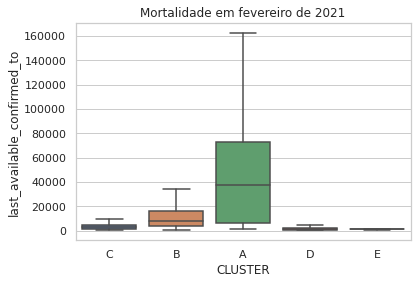

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_confirmed_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em fevereiro de 2021")

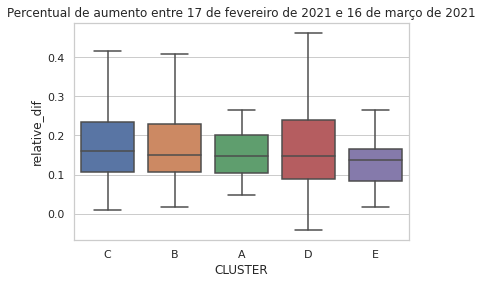

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre 17 de fevereiro de 2021 e 16 de março de 2021")

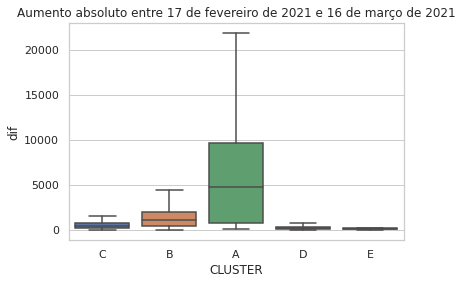

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre 17 de fevereiro de 2021 e 16 de março de 2021")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_confirmed_from_mean=('last_available_confirmed_from','mean'),
    last_available_confirmed_from_median=('last_available_confirmed_from','median'),
    last_available_confirmed_to_mean=('last_available_confirmed_to','mean'),
    last_available_confirmed_to_median=('last_available_confirmed_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_confirmed_from_mean,last_available_confirmed_from_median,last_available_confirmed_to_mean,last_available_confirmed_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,51502.237288,33924.0,59503.237288,37875.0,8001.000000,4778.0,0.166424,0.146877,0.154261
1,B,238,183898.054622,123057.0,9279.882353,6282.5,10775.386555,7562.0,1495.504202,1136.5,0.182713,0.150571,0.161526
2,C,397,74728.382872,51338.0,3489.362720,2540.0,4084.395466,2981.0,595.032746,381.0,0.187485,0.160928,0.173948
3,D,450,39418.280000,30428.5,1628.517778,1282.0,1910.448889,1480.0,281.931111,188.5,0.186404,0.147678,0.175145
4,E,11,39515.181818,24382.0,1440.181818,941.0,1639.272727,1044.0,199.090909,111.0,0.127974,0.136364,0.149633


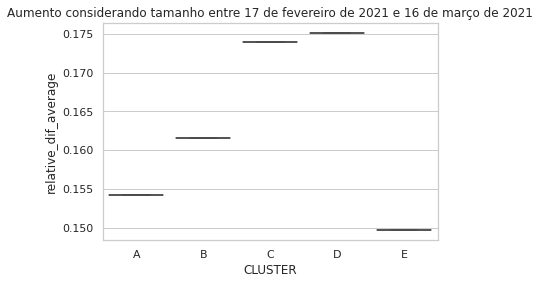

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de fevereiro de 2021 e 16 de março de 2021")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,4778.0
1,B,1136.5
2,C,381.0
3,D,188.5
4,E,111.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
2,C,0.160928
1,B,0.150571
3,D,0.147678
0,A,0.146877
4,E,0.136364


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
3,D,0.175145
2,C,0.173948
1,B,0.161526
0,A,0.154261
4,E,0.149633
